In [28]:
import os

import numpy as np
import pandas as pd

from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.models import Model, load_model, model_from_json
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import SGD, Adam
from keras.callbacks.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import scipy
import scipy.io

In [2]:
# Suppress warning and informational messages
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
# Get count of number of files in this folder and all subfolders
def get_num_files(path):
  if not os.path.exists(path):
    return 0
  return sum([len(files) for r, d, files in os.walk(path)])

In [4]:
# Get count of number of subfolders directly below the folder in path
def get_num_subfolders(path):
  if not os.path.exists(path):
    return 0
  return sum([len(d) for r, d, files in os.walk(path)])

In [5]:
#   Define image generators that will variations of image with the image r/otated slightly, shifted up, down, left, or right, 
#     sheared, zoomed in, or flipped horizontally on the vertical axis (ie. person looking to the left ends up looking to the right)
def create_img_generator():
  return  ImageDataGenerator(
      preprocessing_function=preprocess_input,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      rescale=1./255,     
      horizontal_flip=True
  )

In [6]:
img = load_img( r'./../Storage/train/1/image_06734.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)
datagen = create_img_generator()
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir=r'./../Storage/preview', save_prefix='1', save_format='jpeg'):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely

In [7]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = mpimg.imread(os.path.join(folder, filename))
        if img is not None:
            images.append(img)
    return images

In [8]:
images = load_images(r'./../Storage/preview')

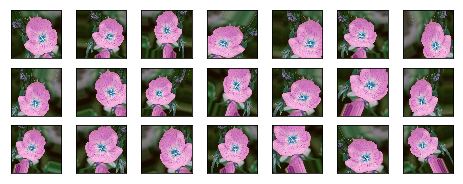

In [9]:
#Print Masked Images after applying KNN
num = get_num_files(r'./../Storage/preview')
itr_img = iter(images)
fig = plt.figure(figsize=(8,3))
for i, img_masked in zip(range(num), itr_img):
    ax = fig.add_subplot(3, 7, 1 + i, xticks=[], yticks=[])
    plt.imshow(img_masked)
plt.show()

In [10]:
# Main Code
Image_width, Image_height = 224, 224 
Training_Epochs = 256 #64
Batch_Size = 32
Number_FC_Neurons = 1024
#LearnRate = 0.001 #1.0e-4

train_dir = r'./../Storage/train'
validate_dir = r'./../Storage/valid'
num_train_samples = get_num_files(train_dir) 
num_classes = get_num_subfolders(train_dir)
num_validate_samples = get_num_files(validate_dir)
num_epoch = Training_Epochs
batch_size = Batch_Size

In [11]:
# Define data pre-processing 
#   Define image generators for training and testing 
train_image_gen = create_img_generator()
test_image_gen = create_img_generator() #ImageDataGenerator(rescale=1./255)

In [12]:
#   Connect the image generator to a folder contains the source images the image generator alters.  
#   Training image generator
train_generator = train_image_gen.flow_from_directory(
  train_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed = 42    #set seed for reproducability
)

Found 6552 images belonging to 102 classes.


In [13]:
#   Validation image generator
validation_generator = test_image_gen.flow_from_directory(
  validate_dir,
  target_size=(Image_width, Image_height),
  batch_size=batch_size,
  seed=42       #set seed for reproducability
)

Found 818 images belonging to 102 classes.


In [51]:
# Load the Inception V3 model and load it with it's pre-trained weights.  But exclude the final 
#    Fully Connected layer
ResNet50_base_model = ResNet50(weights='imagenet', include_top=False) #include_top=False excludes final FC layer
print('ResNet50 base model without last FC loaded')
#print(ResNet50_base_model.summary())     # display the Inception V3 model hierarchy

c:\programdata\anaconda3\envs\datta_tensorflow_gpu\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


ResNet50 base model without last FC loaded


In [59]:
len(ResNet50_base_model.layers)

175

In [60]:
#   Freeze 
Layers_To_Freeze = 170
for layer in ResNet50_base_model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in ResNet50_base_model.layers[Layers_To_Freeze:]:
  layer.trainable = True

In [61]:
# Define the layers in the new classification prediction 
#x = ResNet50_base_model.get_layer('bn5c_branch2a').output
x = ResNet50_base_model.output
x = GlobalMaxPooling2D()(x)
#x = Dense(2048, activation='relu', name = 'Dense_1',
#                  kernel_regularizer=regularizers.l2(0.01),
#                  activity_regularizer=regularizers.l1(0.01))(x)
x = Dense(Number_FC_Neurons, activation='relu')(x) #, kernel_regularizer= regularizers.l2(0.01))(x)        # new FC layer, random init
predictions = Dense(num_classes, activation='softmax')(x)  # new softmax layer

In [62]:
# Define trainable model which links input from the Inception V3 base model to the new classification prediction layers
model = Model(inputs=ResNet50_base_model.input, outputs=predictions)

In [63]:
# print model structure diagram
print (model.summary())

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
____________________________________________________________________________________________

In [46]:
# Option 1: Basic Transfer Learning
print ('\nPerforming Transfer Learning')
#   Freeze all layers in the ResNet50 base model 
for layer in ResNet50_base_model.layers:
  layer.trainable = False


Performing Transfer Learning


Save the model after every epoch

In [47]:
#Model Check point
checkpoint = ModelCheckpoint('resnet50_best_model_copy1.h5',
                            monitor='va_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='max')
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)

In [64]:
#   Define model compile for basic Transfer Learning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Fit the transfer learning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from 
# the training or validation folders and alter them slightly
history_transfer_learning = model.fit_generator(
  train_generator,
  epochs=num_epoch,
  steps_per_epoch = num_train_samples // batch_size,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
  class_weight='auto') #,
  #callbacks=[earlystopping, checkpoint])

Epoch 1/256
204/204 [==============================] - 89s 439ms/step - loss: 4.9132 - accuracy: 0.4589 - val_loss: 4.7922 - val_accuracy: 0.0150
Epoch 2/256
204/204 [==============================] - 89s 436ms/step - loss: 0.8342 - accuracy: 0.7764 - val_loss: 5.1290 - val_accuracy: 0.0102
Epoch 3/256
204/204 [==============================] - 97s 473ms/step - loss: 0.5511 - accuracy: 0.8434 - val_loss: 5.0549 - val_accuracy: 0.0025
Epoch 4/256
 32/204 [===>..........................] - ETA: 1:04 - loss: 0.3691 - accuracy: 0.8955

In [ ]:
# list all data in history
print(history_transfer_learning.history.keys())
# summarize history for accuracy
plt.plot(history_transfer_learning.history['accuracy'])
plt.plot(history_transfer_learning.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_transfer_learning.history['loss'])
plt.plot(history_transfer_learning.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
# Save transfer learning model
model.save('ResNet50-transfer-learning.model')

In [19]:
model = load_model('ResNet50-transfer-learning.model')

In [52]:
# Option 2: Transfer Learning with Fine-tuning - retrain the end few layers (called the top layers) of the ResNet model
print('\nFine tuning existing model')
#   Freeze 
Layers_To_Freeze = 172
for layer in model.layers[:Layers_To_Freeze]:
  layer.trainable = False
for layer in model.layers[Layers_To_Freeze:]:
  layer.trainable = True
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])


Fine tuning existing model


In [53]:
#started at 8:53 PM

In [ ]:
# Fit the Fine-tuning model to the data from the generators.  
# By using generators we can ask continue to request sample images and the generators will pull images from the training or validation
# folders, alter then slightly, and pass the images back
history_fine_tune = model.fit_generator(
  train_generator,
  steps_per_epoch = num_train_samples // batch_size,
  epochs=num_epoch,
  validation_data=validation_generator,
  validation_steps = num_validate_samples // batch_size,
    class_weight='auto')

Epoch 1/64
204/204 [==============================] - 98s 479ms/step - loss: 0.6716 - accuracy: 0.9373 - val_loss: 2.8071 - val_accuracy: 0.4313
Epoch 2/64
204/204 [==============================] - 93s 455ms/step - loss: 0.6109 - accuracy: 0.9535 - val_loss: 2.0712 - val_accuracy: 0.4491
Epoch 3/64
 37/204 [====>.........................] - ETA: 1:07 - loss: 0.5990 - accuracy: 0.9628

In [22]:
# Save fine tuned model
model.save('ResNet50-fine-tune.model')

dict_keys(['loss', 'val_loss', 'val_accuracy', 'accuracy'])


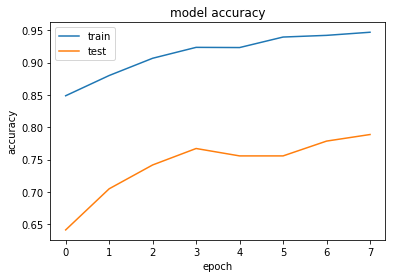

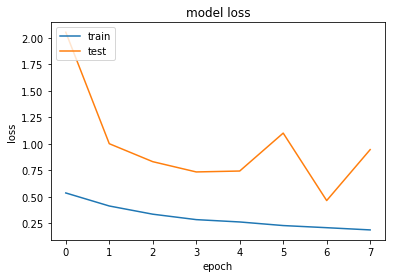

In [23]:
# list all data in history
print(history_fine_tune.history.keys())
# summarize history for accuracy
plt.plot(history_fine_tune.history['accuracy'])
plt.plot(history_fine_tune.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fine_tune.history['loss'])
plt.plot(history_fine_tune.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
#   Validation image generator
test_datagen = ImageDataGenerator()
test_dir = r'./../Storage/test'

In [39]:
#   Validation image generator
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(Image_width, Image_height),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 819 images belonging to 1 classes.


In [40]:
test_generator.reset()

In [41]:
filenames = test_generator.filenames
nb_samples = len(filenames)

In [45]:
pred=model.predict_generator(test_generator,verbose=1,steps = np.ceil(nb_samples/batch_size))

26/26 [==============================] - 20s 757ms/step


In [46]:
predicted_class_indices=np.argmax(pred,axis=1)

In [47]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [50]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [51]:
results

,Filename,Predictions
0,test\image_00005.jpg,89
1,test\image_00006.jpg,73
2,test\image_00024.jpg,96
3,test\image_00025.jpg,30
4,test\image_00029.jpg,96
...,...,...
814,test\image_08133.jpg,89
815,test\image_08134.jpg,88
816,test\image_08144.jpg,88
817,test\image_08172.jpg,78


In [88]:
type(results.Predictions.loc[1])

str

In [89]:
results.Predictions = results.Predictions.astype(np.int64)

In [90]:
type(results.Predictions.loc[1])

numpy.int64

In [91]:
results

,Filename,Predictions
0,test\image_00005.jpg,89
1,test\image_00006.jpg,73
2,test\image_00024.jpg,96
3,test\image_00025.jpg,30
4,test\image_00029.jpg,96
...,...,...
814,test\image_08133.jpg,89
815,test\image_08134.jpg,88
816,test\image_08144.jpg,88
817,test\image_08172.jpg,78


In [52]:
#oxford102_flower_dataset_labels.txt contains a dataset where index is the unique label and column "Names" is the name of the flower for the image label id 
#read labels from oxford102_flower_dataset_labels.txt
oxford102_labels = pd.read_csv('oxford102_flower_dataset_labels.txt', delimiter='\t', header=None, names=['Names'])
# Image labels are 1 based, changed the index of the image database label
oxford102_labels.index = np.arange(1, len(oxford102_labels) + 1)
print(oxford102_labels)
print()
print("Test Print: FLower Name and its unique label")
print(oxford102_labels.loc[77])

                            Names
1                 'pink primrose'
2     'hard-leaved pocket orchid'
3              'canterbury bells'
4                     'sweet pea'
5              'english marigold'
..                            ...
98              'mexican petunia'
99                     'bromelia'
100              'blanket flower'
101             'trumpet creeper'
102             'blackberry lily'

[102 rows x 1 columns]

Test Print: FLower Name and its unique label
Names     'passion flower'
Name: 77, dtype: object


In [75]:
oxford102_labels.reset_index(level=0, inplace=True)

In [76]:
oxford102_labels.head()

,index,Names
0,1,'pink primrose'
1,2,'hard-leaved pocket orchid'
2,3,'canterbury bells'
3,4,'sweet pea'
4,5,'english marigold'


In [84]:
oxford102_labels.rename({'index': 'Predictions'}, axis=1, inplace=True)

In [85]:
oxford102_labels.columns

Index(['Predictions', 'Names'], dtype='object')

In [92]:
merge_predictions = pd.merge(results, oxford102_labels, on='Predictions')

In [93]:
merge_predictions

,Filename,Predictions,Names
0,test\image_00005.jpg,89,'watercress'
1,test\image_00099.jpg,89,'watercress'
2,test\image_00202.jpg,89,'watercress'
3,test\image_00282.jpg,89,'watercress'
4,test\image_00324.jpg,89,'watercress'
...,...,...,...
814,test\image_06460.jpg,44,'poinsettia'
815,test\image_07234.jpg,44,'poinsettia'
816,test\image_07090.jpg,4,'sweet pea'
817,test\image_07250.jpg,27,'prince of wales feathers'


In [95]:
merge_predictions.loc[merge_predictions['Filename'] == 'test\image_00006.jpg']

,Filename,Predictions,Names
65,test\image_00006.jpg,73,'water lily'


In [97]:
oxford102_labels.loc[72]

Predictions               73
Names           'water lily'
Name: 72, dtype: object

In [102]:
#imagelabels.mat contains labels of the images and number of images for each label
#labels and unique are the lists that contain the label ids and respective number of images 
mat = scipy.io.loadmat('imagelabels.mat')
labels = mat['labels'].tolist()
unique, counts = np.unique(labels, return_counts=True)

In [103]:
#find a flower label from flower image name
def find_flower_label_from_flower_image_name(flower_image_name):
    flower_id = flower_image_name.split('_')[1].split('.')[0]
    flower_id_int = int(flower_id)
    return labels[0][flower_id_int - 1]

In [134]:
#Find the name of the flower from the image name from the image database
def find_flower_category_name(file_path):
    flower_name = file_path.split("\\")[-1]
    flower_label = find_flower_label_from_flower_image_name(flower_name)
    flower_category_name = oxford102_labels.Names.loc[flower_label]
    return flower_category_name.replace("'", '').strip()

In [135]:
find_flower_category_name('test\image_00006.jpg')

'lotus'